In [43]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]

# from tqdm.notebook import tqdm
from numpy.random import default_rng
# from scipy.optimize import root_scalar
# from scipy.interpolate import interp1d
# from scipy.stats import norm, chi2

orig_path="/Users/sebhoof/Research/BHSR/"

#sys.path.append("../code_matt/")
rng = default_rng()

#from BH_functions import stellar_functions

from py.plotting import *
from py.constants import *
from py.bhsr import *
from py.bosenova import *

!mkdir -p figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example plots for solar BH mass and spin samples

m = 14.77 +/- 0.95, a = 1.00 +/- 0.01


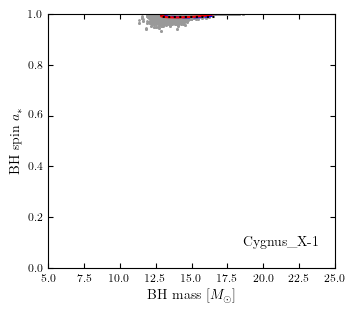

In [44]:
# Cygnus X-1
cygX1_m = []
cygX1_a = []
for i in range(3):
   dat = np.genfromtxt("data/raw/solar/Cygnus_X-1/sp{:d}.txt".format(i+1))
   cygX1_m.append(dat[:,1])
   cygX1_a.append(dat[:,4])
cygX1_m = np.concatenate(cygX1_m)
cygX1_a = np.concatenate(cygX1_a)

plot_m_a(cygX1_m, cygX1_a, label='Cygnus_X-1',)

m = 15.67 +/- 1.49, a = 0.83 +/- 0.06


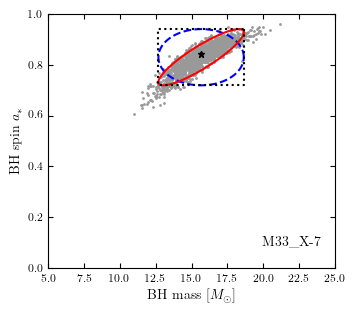

In [45]:
# M33_X-7
data = np.genfromtxt("data/raw/solar/M33_X-7/f3_data_tex.txt")
m33x7_a0 = 0.77 + 0.068
a0 = data[:,0]
m0 = data[:,1]
m33x7_a = -0.2 + (a0-154.560)*(0.1+0.2)/(369.920-154.560) + m33x7_a0
m33x7_m = 12 + (m0-665.600)*(20-12)/(880.960-665.600)

plot_m_a(m33x7_m, m33x7_a, label='M33_X-7', bfit=[15.65, 0.84])

m = 11.10 +/- 1.53, a = 0.60 +/- 0.16


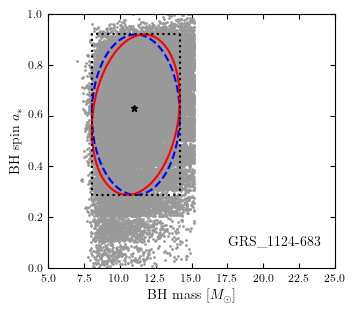

In [46]:
# Nova_Muscae_1991 aka GRS 1124-683
nm_files = !ls {orig_path}bh_data/raw/Nova_Muscae_1991/*npy
nm91_m, nm91_a = [], []
for nmf in nm_files:
   dat = np.load(nmf)
   nm91_m.append(dat[:,1])
   nm91_a.append(dat[:,6])
nm91_m = np.concatenate(nm91_m)
nm91_a = np.concatenate(nm91_a)

plot_m_a(nm91_m, nm91_a, label='GRS_1124-683', bfit=[11.0,0.63])

### Functions for $P_\text{ex}$

In [49]:
ma_test = 7e-12
states = np.array([(i,j,j) for i in range(7) for j in range(1,i)])

# MC exclusion check for M33-X7
n_samples_ref = 100000
astar_ref, lgm_ref = rng.normal(loc=0.84, scale=0.05, size=n_samples_ref), np.log10(rng.normal(loc=15.56, scale=1.45, size=n_samples_ref))

mc_test = []
mc_gammas = []
for m,a in zip(m33x7_m, m33x7_a):
    check = 1
    for s in states:
        gam = GammaSR_nlm_mod(ma_test, m, a, *s)
        if s[0] == 2:
            mc_gammas.append(gam/inv_tSR)
        if gam > inv_tSR:
            check = 0
            break
    mc_test.append(check)
p_ex_mc = 100*(1.0-sum(mc_test)/len(mc_test))
print('P_ex = {:.2f}%'.format(p_ex_mc))

P_ex = 99.95%


In [50]:
n_samples_ref = 100000

def get_gaussian_samples(m_mean, m_std, a_mean, a_std, n=n_samples_ref):
    return rng.normal(loc=m_mean, scale=m_std, size=n), rng.normal(loc=a_mean, scale=a_std, size=n)

cygX1_m_gauss, cygX1_a_gauss = get_gaussian_samples(14.8, 1.0, 1.0, (1.0-0.983)/3.0)
nm91_m_gauss, nm91_a_gauss = get_gaussian_samples(11.0, 1.4, 0.63, 0.16)

In [51]:
bh_names = ['Cygnus X-1', 'GRS 1124-683', 'M33 X-7']
bh_indices = {
    'Cygnus X-1': 2,
    'Cyg X-1': 2,
    'GRO J1655-40': 3, 
    'GRS1915+105': 4,
    'M33 X-7': 13,
    'LMC X-1': 11,
}

bh_data = { 'Cygnus X-1': (cygX1_m, cygX1_a), 'GRS 1124-683': (nm91_m, nm91_a), 'M33 X-7': (m33x7_m, m33x7_a) }
bh_gaussian_data = { 'Cygnus X-1': (cygX1_m_gauss, cygX1_a_gauss), 'GRS 1124-683': (nm91_m_gauss, nm91_a_gauss), 'M33 X-7': (10**lgm_ref, astar_ref) }

In [52]:
def mc_integration(mu, data, states):
    temp = []
    for m,a in zip(*data):
        check = 1
        a0 = np.minimum(1, a)
        for s in states:
            if GammaSR_nlm_mod(mu, m, a0, *s) > inv_tSR:
                check = 0
                break
        temp.append(check)
    p_ex = 100.0*(1.0-sum(temp)/len(temp))
    return p_ex

def get_excl_prob(mu, bh_name, states, out=True):
    p_ex_full = mc_integration(mu, bh_data[bh_name], states)
    p_ex_gauss = mc_integration(mu, bh_gaussian_data[bh_name], states)
    if out:
        print('{}: P_ex = {:.2f}% (Full MC), {:.2f}% (Gauss MC)'.format(bh_name, p_ex_full, p_ex_gauss))
    return p_ex_full, p_ex_gauss

"""
def get_excl_prob_matt(lgmu, bh_name, states):
    p_ex_matt = []
    for m in lgmu:
        try:
            temp = 100*stellar_functions[bh_indices[bh_name]](m,18)[0]
        except:
            temp = m # np.full_like(lgmu, fill_value=np.nan)
        p_ex_matt.append(temp)
    return np.array(p_ex_matt)

def get_excl_prob_all(mu, bh_name, states, out=True):
    p_ex_full = mc_integration(mu, bh_data[bh_name], states)
    p_ex_gauss = mc_integration(mu, bh_gaussian_data[bh_name], states)
    try:
        p_ex_matt = 100*stellar_functions[bh_indices[bh_name]](np.log10(mu),18)[0]
    except:
        p_ex_matt = np.nan
    if out:
        print('{}: P_ex = {:.2f}% (Full MC), {:.2f}% (Gauss MC), {:.2f}% (Matt\'s code)'.format(bh_name, p_ex_full, p_ex_gauss, p_ex_matt))
    return p_ex_full, p_ex_gauss, p_ex_matt
""";

table_string = ""
for bh in bh_names:
    p1, p2 = get_excl_prob(ma_test, bh, states)
    table_string += "{} & {:.2f} & {:.2f} \\\\\n".format(bh, p1, p2)
print(table_string)

Cygnus X-1: P_ex = 100.00% (Full MC), 100.00% (Gauss MC)
GRS 1124-683: P_ex = 74.41% (Full MC), 77.50% (Gauss MC)
M33 X-7: P_ex = 99.95% (Full MC), 100.00% (Gauss MC)
Cygnus X-1 & 100.00 & 100.00 \\
GRS 1124-683 & 74.41 & 77.50 \\
M33 X-7 & 99.95 & 100.00 \\



### Trying to reproduce Masha's results

From [arXiv:1411.2263](https://arxiv.org/pdf/1411.2263.pdf)

In [2]:
masha_data = [
    ['M33 X-7', 3e6, 15.56, 1.45, 0.84, 0.1, 0.1],
    ['LMC X-1', 5e6, 10.91, 1.4, 0.92, 0.06, 0.18],
    ['GRO J1655-40', 3.4e8, 6.3, 0.5, 0.72, 0.16, 0.24],
    ['Cyg X-1', 4.8e6, 14.8, 1.0, 1.0, 0.0, 0.005],
    ['GRS1915+105', 4e9, 10.1, 0.6, 1.0, 0.0, 0.025]
]

In [16]:
#lgmuvals = np.linspace(-13, -9, 200)
lgmuvals = np.linspace(-14, -9, 200)
lginvfvals = np.linspace(-20, -10, 100)

grid_x = [[m for m in lgmuvals] for _ in lginvfvals]
grid_y = [[f for _ in lgmuvals] for f in lginvfvals]
    

states = [(ell+1, ell, ell) for ell in range(1,6)]
    
def test_for_index_old(i, lgmu, lginvf):
    mu = 10**lgmu
    invf = 10**lginvf
    _, tbh, mbh, mbh_err, a, a_err_p, a_err_m = masha_data[i]
    tbh = min(tEddington_in_yr, tbh)
    mbh_p, mbh_m = mbh+2*mbh_err, max(0,mbh-2*mbh_err)
    _, a_m = min(0.99, a+2*a_err_p), max(0, a-2*a_err_m)
    excluded = 0
    res = [0, 0]
    for s in states:
        n, l, m = s
        # Check SR condition
        if alpha(mu, mbh_m)/l <= 0.5:
            excluded += is_sr_mode(mu, mbh_m, a_m, tbh, n, l, m)
            #excluded *= is_sr_mode(mu, mbh_m, a_p, tbh, n, l, m)
            excluded *= not_bosenova_is_problem(mu, invf, mbh_m, a_m, tbh, n, l, m)
            res[0] = excluded
        if alpha(mu, mbh_p)/l <= 0.5:
            excluded += is_sr_mode(mu, mbh_p, a_m, tbh, n, l, m)
            #excluded *= is_sr_mode(mu, mbh_p, a_p, tbh, n, l, m)
            excluded *= not_bosenova_is_problem(mu, invf, mbh_p, a_m, tbh, n, l, m)
            res[1] = excluded
        #if excluded > 0:
        #    return 1
        if res[0]*res[1] > 0:
            return 1
    return 0

def test_for_index_new(i, lgmu, lginvf):
    mu = 10**lgmu
    invf = 10**lginvf
    _, tbh, mbh, mbh_err, a, a_err_p, a_err_m = masha_data[i]
    tbh = min(tEddington_in_yr, tbh)
    mbh_p, mbh_m = mbh+2*mbh_err, max(0,mbh-2*mbh_err)
    a_p, a_m = min(0.99, a+2*a_err_p), max(0, a-2*a_err_m)
    excluded = 1
    sr_rates = []
    for s in states:
        n, l, m = s
        sr_rates.append([GammaSR_nlm_mod(mu, mbh_m, a_m, n, l, m),
                         GammaSR_nlm_mod(mu, mbh_m, a_p, n, l, m),
                         GammaSR_nlm_mod(mu, mbh_p, a_m, n, l, m),
                         GammaSR_nlm_mod(mu, mbh_p, a_p, n, l, m)])
    sr_rates = np.array(sr_rates)
    sr_rates_min = [np.nanmin(sr_rates[:,i]) for i in range(4)]
    indices = [np.where(sr_rates[:,i] == sr_rates_min[i])[0][0] for i in range(4)]
    n_min = [states[i][0] for i in indices]
    l_min = [states[i][1] for i in indices]
    for sr,n,l,m in zip(sr_rates_min,n_min,l_min,2*[mbh_m]+2*[mbh_p]):
        excluded *= is_sr_mode_min(mu, sr, m, tbh)*not_bosenova_is_problem_min(mu, sr, invf, m, tbh, n)
    return excluded

def test_for_index(i, lgmu, lginvf):
    mu = 10**lgmu
    invf = 10**lginvf
    _, tbh, mbh, mbh_err, a, a_err_p, a_err_m = masha_data[i]
    tbh = min(tEddington_in_yr, tbh)
    sigma_level = 2
    mbh_p, mbh_m = mbh+sigma_level*mbh_err, max(0,mbh-sigma_level*mbh_err)
    _, a_m = min(0.99, a+sigma_level*a_err_p), max(0, a-sigma_level*a_err_m)
    # excluded = [0,0] 
    # TODO: make sure that we rule out the point if for mbh- any SR state exists,
    # and for mbh+ any (other) SR state exists
    for i,mm in enumerate(np.linspace(mbh_m, mbh_p, 20)):
        sr_rates = []
        sr_checks = []
        for s in states:
            n, l, m = s
            if (alpha(mu, mm)/l <= 0.5):
                sr = GammaSR_nlm_mod(mu, mm, a_m, n, l, m)
                #sr = GammaSR_nlm_nr(mu, mm, a_m, n, l, m)
                sr_rates.append(sr)
                sr_checks.append(is_sr_mode_min(mu, sr, mm, tbh)*not_bosenova_is_problem_min(mu, sr, invf, mm, tbh, n))
        if len(sr_rates) == 0:
            return 0
        #sr_rates_min = np.nanmax(sr_rates)
        #index = np.where(sr_rates == sr_rates_min)[0][0]
        #excluded[i] = sr_checks[index]
        if sum(sr_checks) == 0:
            return 0
    return 1

def test_for_index_simon(i, lgmu, lginvf):
    mu = 10**lgmu
    invf = 10**lginvf
    _, tbh, mbh, mbh_err, a, a_err_p, a_err_m = masha_data[i]
    tbh = min(tEddington_in_yr, tbh)
    sigma_level = 2
    mbh_p, mbh_m = mbh+sigma_level*mbh_err, max(0,mbh-sigma_level*mbh_err)
    _, a_m = min(0.99, a+sigma_level*a_err_p), max(0, a-sigma_level*a_err_m)
    for i,mm in enumerate(np.linspace(mbh_m, mbh_p, 20)):
        sr_rates = []
        inv_t = inv_eVs / (yr_in_s*tbh)
        if (alpha(mu, mm)/2 <= 0.5):
            sr0 = GammaSR_nlm_mod(mu, mm, a_m, 2, 1, 1)
            if sr0 > inv_t:
                sr = sr0*n_eq_211(mu, mm, a_m, 1/invf)
                sr_rates.append(sr)
                if sr > inv_t:
                    return 0
                else:
                    return 1
            else:
                sr_rates.append(sr0)
                return 1
        if len(sr_rates) == 0:
            return 0
    return 1

grid_z0 = [[test_for_index_simon(0, m, f) for m in lgmuvals] for f in lginvfvals]
grid_z1 = [[test_for_index_simon(1, m, f) for m in lgmuvals] for f in lginvfvals]
grid_z2 = [[test_for_index_simon(2, m, f) for m in lgmuvals] for f in lginvfvals]
grid_z3 = [[test_for_index_simon(3, m, f) for m in lgmuvals] for f in lginvfvals]
grid_z4 = [[test_for_index_simon(4, m, f) for m in lgmuvals] for f in lginvfvals]

In [17]:
#matt_grids = np.array([get_excl_prob_matt(more_lgmuvals, masha_data[i][0], states)/100.0 for i in range(5)])

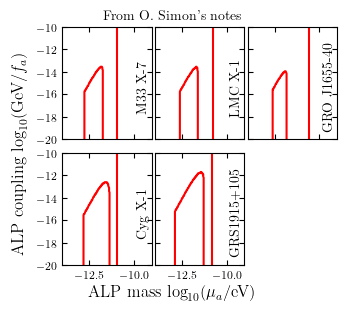

In [18]:
grids = [grid_z0, grid_z1, grid_z2, grid_z3, grid_z4]

fig, axes = plt.subplots(2, 3, figsize=(3.375,3), sharex=True, sharey=True)
#for g,gm,ax,m in zip(grids,matt_grids,axes.flat,masha_data):
for g,ax,m in zip(grids,axes.flat,masha_data):
    #ax.contourf(grid_x, grid_y, g)
    ax.contour(grid_x, grid_y, g, levels=[0,1], colors='r')
    ax.text(-9.5, -15.5, m[0], ha='center', va='center', rotation=90, c='k')
    ax.set_xlim([-14,-9])
    ax.set_ylim([-20,-10])
axes[-1,-1].axis('off')
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.supxlabel(r"ALP mass $\log_{10}(\mu_a/\text{eV})$")
fig.supylabel(r"ALP coupling $\log_{10}(\text{GeV}/f_a)$")
fig.suptitle(r"From O. Simon's notes")
fig.tight_layout(pad=0.25)
#fig.savefig("figures/reproduced_exclusions_2d.pdf", backend='pgf')
plt.show()

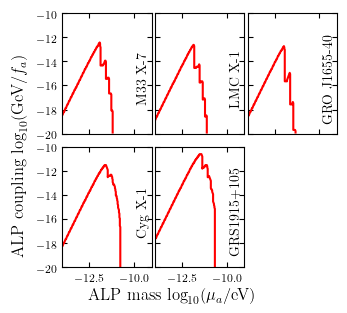

In [36]:
grids = [grid_z0, grid_z1, grid_z2, grid_z3, grid_z4]

fig, axes = plt.subplots(2, 3, figsize=(3.375,3), sharex=True, sharey=True)
#for g,gm,ax,m in zip(grids,matt_grids,axes.flat,masha_data):
for g,ax,m in zip(grids,axes.flat,masha_data):
    #ax.contourf(grid_x, grid_y, g)
    ax.contour(grid_x, grid_y, g, levels=[0,1], colors='r')
    ax.text(-9.5, -15.5, m[0], ha='center', va='center', rotation=90, c='k')
    ax.set_xlim([-14,-9])
    ax.set_ylim([-20,-10])
axes[-1,-1].axis('off')
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.supxlabel(r"ALP mass $\log_{10}(\mu_a/\text{eV})$")
fig.supylabel(r"ALP coupling $\log_{10}(\text{GeV}/f_a)$")
fig.tight_layout(pad=0.25)
fig.savefig("figures/reproduced_exclusions_2d.pdf", backend='pgf')
plt.show()

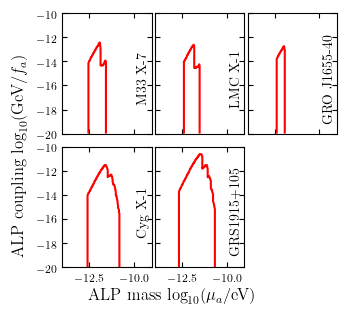

In [31]:
grids = [grid_z0, grid_z1, grid_z2, grid_z3, grid_z4]

fig, axes = plt.subplots(2, 3, figsize=(3.375,3), sharex=True, sharey=True)
#for g,gm,ax,m in zip(grids,matt_grids,axes.flat,masha_data):
for g,ax,m in zip(grids,axes.flat,masha_data):
    #ax.contourf(grid_x, grid_y, g)
    ax.contour(grid_x, grid_y, g, levels=[0,1], colors='r')
    ax.text(-9.5, -15.5, m[0], ha='center', va='center', rotation=90, c='k')
    ax.set_xlim([-14,-9])
    ax.set_ylim([-20,-10])
axes[-1,-1].axis('off')
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
fig.supxlabel(r"ALP mass $\log_{10}(\mu_a/\text{eV})$")
fig.supylabel(r"ALP coupling $\log_{10}(\text{GeV}/f_a)$")
fig.tight_layout(pad=0.25)
fig.savefig("figures/reproduced_exclusions_2d.pdf", backend='pgf')
plt.show()

In [25]:
# Make comparison for M33-X7

lgmrange = np.arange(-14, -10, 0.05)

pex_m33x7 = [get_excl_prob(10**lgm, 'M33 X-7', states, out=False) for lgm in tqdm(lgmrange)]
pex_m33x7 = np.array(pex_m33x7)
pex_m33x7_masha = np.array([test_for_index(0, lgm, -18) for lgm in lgmrange])

  0%|          | 0/80 [00:00<?, ?it/s]

NameError: name 'get_excl_prob' is not defined

In [ ]:
from scipy.stats import chi2
from scipy.interpolate import interp1d 
from scipy.integrate import quad

#print(chi2.ppf(0.9545, df=1))
marg_ll = interp1d(lgmrange, 1-0.01*pex_m33x7[:,0])
post_norm, post_norm_err = quad(lambda x: marg_ll(x), -13.9, -10.1)
print(post_norm, post_norm_err)

In [ ]:
"""
fig, ax = plt.subplots()
ax.plot(lgmrange, 0.01*(pex_m33x7[:,0]-pex_m33x7[:,2]), 'b-', label='Full')
ax.plot(lgmrange, 0.01*(pex_m33x7[:,1]-pex_m33x7[:,2]), 'r--', label='Gaussian')
ax.plot(lgmrange, pex_m33x7_masha-0.01*pex_m33x7[:,2], 'k:', label="Masha++")
#ax.plot(lgmrange, pex_m33x7[:,2]/100 - pex_matt[:,1], 'orange', label=r"Matt's code")
ax.set_title('M33-X7')
ax.set_xlabel(r'ULA mass $\mu_\text{ax}$')
ax.set_ylabel("Excl. prob. - Matt\'s result")
ax.set_ylim([-1,1])
ax.legend()
plt.show()
""";

fig, ax = plt.subplots(figsize=(3.375,3.375))

#ax.plot(lgmrange, 1-0.01*pex_m33x7[:,2], c='purple', ls='--', label=r"Stott + Marsh '18")
ax.plot(lgmrange, 1-0.01*pex_m33x7[:,0], 'b-', label="Direct Monte Carlo")
ax.plot(lgmrange, 1-0.01*pex_m33x7[:,1], c='grey', ls=':', lw=2, label="Gaussian")
ax.plot(lgmrange, 1-pex_m33x7_masha, 'r--', label=r"$\approx$ Arvanitaki+ '15")
ax.plot([-16,-8], 2*[1-0.9545], 'k:', label=r"Naive $2\sigma$")
ax.plot([-16,-8], 2*[np.exp(-0.5*4)], 'k--', label=r"Wilks' $2\sigma$ (1 DOF)")

ax.set_title('M33 X-7 Exclusion')
ax.set_xlabel(r"ULA mass $\log_{10}(\mu_\text{ax}/\text{eV})$")
ax.set_ylabel("Marginal likelihood")
ax.set_xlim([-14,-10])
ax.set_ylim([-0.03,1.03])
ax.legend(loc='center', bbox_to_anchor=(0.51,0.75))
fig.tight_layout()
fig.savefig("figures/marginal_likelihood.pdf", backend='pgf')
plt.show()